# Predicting Pneumonia in X-Ray Images
##### -Harshul Varma
***

## Introduction 

According to the World Health Organization (WHO), pneumonia kills about 2 million children under 5 years old every year and is consistently estimated as the single leading cause of childhood mortality (Rudan et al., 2008), killing more children than HIV/AIDS, malaria, and measles combined (Adegbola, 2012). One key element of diagnosis is radiographic data, since chest X-rays are routinely obtained as standard of care and can help differentiate between different types of pneumonia. However, rapid radiologic interpretation of images is not always available, particularly in the low-resource settings where childhood pneumonia has the highest incidence and highest rates of mortality. Thus in this notebook I investigate the use of Deep Learning to help diagnose Pneumonia in X-Ray images.

In [0]:
#Importing Libraries
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
import fnmatch
from pathlib import Path
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.utils import to_categorical,normalize
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from sklearn.utils import shuffle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip "/content/drive/My Drive/Datasets/chest-xray-pneumonia.zip"

In [0]:
img_path =  "/content/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg"

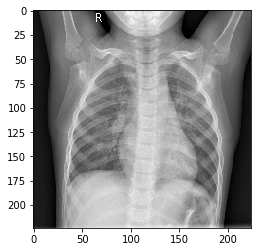

In [0]:
#Looking at a sample image
img = cv2.imread(img_path)
re = cv2.resize(img,(224,224))
plt.imshow(re)

In [0]:
#defining training and test paths
train_path = "/content/chest-xray-pneumonia/chest_xray/chest_xray/train/"
test_path = "/content/chest-xray-pneumonia/chest_xray/chest_xray/test/"

In [0]:
#function to create Images (X) and Labels (y)
def create_data(path):
    X = []
    y = []
    
    normal_data = (path+"NORMAL/*.jpeg")
    pneumonia_data = (path+"PNEUMONIA/*.jpeg")
    
    for fname in glob(normal_data):
        im = cv2.imread(fname)
        im = cv2.resize(im,(100,100))
        X.append(im)
        y.append(0)
        
    for fname in glob(pneumonia_data):
        im = cv2.imread(fname)
        im = cv2.resize(im,(100,100))
        X.append(im)
        y.append(1)     
        
    return X,y

In [0]:
X_train,y_train = create_data(train_path)
X_test,y_test = create_data(test_path)

Text(0.5, 1.0, '0')

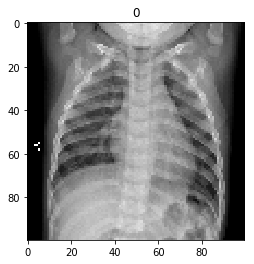

In [0]:
#Plotting a sample image
plt.imshow(X_train[0])
plt.title(y_train[0])

In [0]:
#percentage of Pneumonia cases in train and test set
print('Percentage of Pneumonia cases in train set: ',round(y_train.count(1)/(y_train.count(1)+y_train.count(0))*100,1))
print('Percentage of Pneumonia cases in test set: ',round(y_test.count(1)/(y_test.count(1)+y_test.count(0))*100,1))

Percentage of Pneumonia cases in train set:  74.3
Percentage of Pneumonia cases in test set:  62.5


In [0]:
#converting to anarray
X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
#converting to one hot vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
X_train, y_train = shuffle(X_train,y_train, random_state=0)
X_test, y_test = shuffle(X_test,y_test, random_state=0)

In [0]:
#Checking the shape of the arrays
print("X Training Data Shape:", X_train.shape)
print("Y training Data Shape:", y_train.shape)

print("X Testing Data Shape:", X_test.shape)
print("Y Testing Data Shape:", y_test.shape)

X Training Data Shape: (5216, 100, 100, 3)
Y training Data Shape: (5216, 2)
X Testing Data Shape: (624, 100, 100, 3)
Y Testing Data Shape: (624, 2)


In [0]:
#Loading the model for transfer learning
base_model = ResNet50(weights='imagenet',include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
#Building a model to be added on top of the ResNet50 architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128,activation='relu')(x)
preds = Dense(2,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#Freezing all layers except the first 20
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
#Data Augmentation 
datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10)  


In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
#model callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
mcp_save = ModelCheckpoint('xray_weights.hdf5', save_best_only=True, monitor='val_acc', mode='max')

In [0]:
#Running the model
history = model.fit_generator(datagen.flow(X_train,y_train),steps_per_epoch=len(X_train) / 128, epochs=10,validation_data=(X_test,y_test),callbacks=[lr_reduce,mcp_save])

Epoch 1/10
163/163 [==============================] - 107s 658ms/step - loss: 0.1904 - acc: 0.9329 - val_loss: 3.2283 - val_acc: 0.6971
Epoch 2/10
624/624 [==============================] - 1s 1ms/sample - loss: 10.1810 - acc: 0.3013

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
163/163 [==============================] - 27s 163ms/step - loss: 0.1367 - acc: 0.9540 - val_loss: 10.0637 - val_acc: 0.3013
Epoch 3/10
163/163 [==============================] - 26s 158ms/step - loss: 0.1000 - acc: 0.9645 - val_loss: 0.7880 - val_acc: 0.7740
Epoch 4/10
163/163 [==============================] - 25s 156ms/step - loss: 0.0777 - acc: 0.9734 - val_loss: 0.2583 - val_acc: 0.9006
Epoch 5/10
624/624 [==============================] - 1s 1ms/sample - loss: 0.2749 - acc: 0.8958

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
163/163 [==============================] - 24s 150ms/step - loss: 0.0748 - acc: 0.9760 - val_loss: 0.2744 - va

In [0]:
#Loading the best model weights
model.load_weights('xray_weights.hdf5')

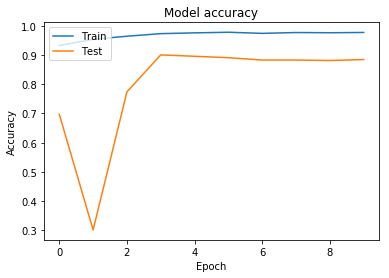

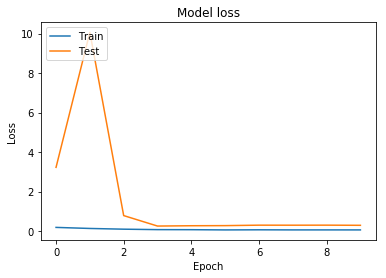

In [0]:
#Plotting the accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#using model to predict from test data
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

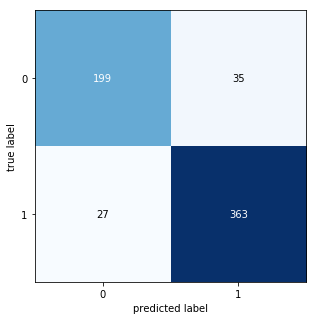

In [0]:
#Plotting the confusion matrix
CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [0]:
#Calculating the f1 score, precision and recall
f1 = f1_score(y_true, pred, average='weighted')
precision = precision_score(y_true, pred, average='weighted')  
recall = recall_score(y_true, pred, average='weighted')  

In [0]:
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

F1 Score: 0.9002813948355771
Precision: 0.9002368034864588
Recall: 0.9006410256410257


***